In [4]:
import csv 
import io
import pyspark
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import ast
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# Data processing

In [5]:
#conf = pyspark.SparkConf().setMaster("local[*]").setAppName("My App")
#sc = pyspark.SparkContext(conf = conf)
#sqlContext = SQLContext(sc)
#spark = SparkSession.builder.getOrCreate()

# Ci fa andare OUT OF MEMORY

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('My App') \
    .getOrCreate()

### Load units

In [7]:
df=pd.read_csv('data_full_encoded_units.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("levels", IntegerType(), True),
                        StructField("units_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot=dfs.groupBy("index").pivot("units_lst").sum("levels")

df_pivot.printSchema()

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


root
 |-- index: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fiora: long (nullable = true)
 |-- Garen: long (nullable = true)
 |-- Hecarim: long (nullable = true)
 |-- Irelia: long (nullable = true)
 |-- Janna: long (nullable = true)
 |-- JarvanIV: long (nullable = true)
 |-- Jax: long (nullable = true)
 |-- Jhin: long (nullable = true)
 |-- Jinx: long (nullable = true)
 |-- Kalista: long (nullable = true)
 |-- Katarina: long (nullable = true)
 |-- Kayn: long (nullable = true)
 |-- Kennen: long (nullable = true)
 |-- Kindred: long (nullable = true)
 |-- LeeSin: long (nullable = 

In [8]:
#df_pivot.show(3)

### Load traits

In [9]:
df=pd.read_csv('data_full_encoded_traits.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("traits_level", IntegerType(), True),
                        StructField("traits_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot2=dfs.groupBy("index").pivot("traits_lst").sum("traits_level")

df_pivot2.printSchema()

root
 |-- index: string (nullable = true)
 |-- Adept: long (nullable = true)
 |-- Assassin: long (nullable = true)
 |-- Boss: long (nullable = true)
 |-- Brawler: long (nullable = true)
 |-- Cultist: long (nullable = true)
 |-- Dazzler: long (nullable = true)
 |-- Divine: long (nullable = true)
 |-- Duelist: long (nullable = true)
 |-- Dusk: long (nullable = true)
 |-- Elderwood: long (nullable = true)
 |-- Emperor: long (nullable = true)
 |-- Enlightened: long (nullable = true)
 |-- Exile: long (nullable = true)
 |-- Fortune: long (nullable = true)
 |-- Hunter: long (nullable = true)
 |-- Keeper: long (nullable = true)
 |-- Mage: long (nullable = true)
 |-- Moonlight: long (nullable = true)
 |-- Mystic: long (nullable = true)
 |-- NaN: long (nullable = true)
 |-- Ninja: long (nullable = true)
 |-- Shade: long (nullable = true)
 |-- Sharpshooter: long (nullable = true)
 |-- Spirit: long (nullable = true)
 |-- Tormented: long (nullable = true)
 |-- Vanguard: long (nullable = true)
 |-- 

In [10]:
#df_pivot2.show(3)

### Load data

In [11]:
data=pd.read_csv('data_modificato.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("patch_version", StringType(), True),
                        StructField("match_id", StringType(), True),
                        StructField("puuid", StringType(), True),
                        StructField("placement", IntegerType(), True),
                        StructField("level", IntegerType(), True),
                        StructField("gold_left", IntegerType(), True),
                        StructField("last_round", IntegerType(), True),
                        StructField("time_in_game", FloatType(), True),
                        StructField("total_dmg_to_players", IntegerType(), True),
                        StructField("players_eliminated", IntegerType(), True),
                        StructField("chosen_unit", StringType(), True),
                        StructField("chosen_trait", StringType(), True),
                        StructField("units", StringType(), True),
                        StructField("traits", StringType(), True),
                        StructField("units_lst", StringType(), True),
                        StructField("levels", StringType(), True),
                        StructField("traits_lst", StringType(), True),
                        StructField("traits_level", StringType(), True)])

data_spark = spark.createDataFrame(data, schema=df_schema)
data_spark.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- units: string (nullable = true)
 |-- traits: string (nullable = true)
 |-- units_lst: string (nullable = true)
 |-- levels: string (nullable = true)
 |-- traits_lst: string (nullable = true)
 |-- traits_level: string (nullable = true)



In [12]:
data_spark=data_spark.drop('units', 'traits', 'units_lst', 'levels', 'traits_lst', 'traits_level')

In [13]:
#data_spark.show(3)

Merge datasets

In [14]:
data_final=data_spark.join(df_pivot, on='index')
data_final=data_final.join(df_pivot2, on='index')

In [15]:
data_final=data_final.drop('NaN')
data_final.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fio

In [16]:
#data_final.show(3)

## Handling NaN and Null values

In [17]:
# Function to check NaN values

def count_nulls(sparkdf):#input pyspark df, return a list with nan and relative value
    null_counts=[]
    for col in sparkdf.dtypes:
        thename = col[0]
        thetype = col[1]
        nulls = sparkdf.where(sparkdf[thename].isNull()).count()
        result =tuple([thename,nulls])
        null_counts.append(result)
    null_counts=[(x,y) for (x.y) in null_counts if y!=0]
    return null_counts

In [18]:
#count_nulls(data_final) #Check the NaN values inside the spark dataframe

In [19]:
data_final_clean = data_final.replace(float('NaN'), None)
#data_final_clean.show()

In [20]:
#data_final_clean.show(3)

In [21]:
data_final_clean = data_final_clean.na.fill(value=0) #replacing all null values with 0
data_final_clean.show(3)

+------+-------------+---------------+--------------------+---------+-----+---------+----------+------------+--------------------+------------------+-----------+------------+------+----+-----+-----+--------+----+----+----------+-----+-----+-------+------+-----+-----+-------+------+-----+--------+---+----+----+-------+--------+----+------+-------+------+------+---------+----+---+------+-------+----+-------+----+----+-----+-------+----+----+-----+---------+-----+-----+------+-----------+-----+------+---+-------+------+-------+-----+----+-----+---+------+-----+--------+----+-------+-------+-------+------+-------+----+---------+-------+-----------+-----+-------+------+------+----+---------+------+-----+-----+------------+------+---------+--------+-------+
| index|patch_version|       match_id|               puuid|placement|level|gold_left|last_round|time_in_game|total_dmg_to_players|players_eliminated|chosen_unit|chosen_trait|Aatrox|Ahri|Akali|Annie|Aphelios|Ashe|Azir|Cassiopeia|Diana|Elis

## Vector Assembler & Classification

In [19]:
data_class = data_final_clean.drop('index','patch_version', 'match_id', 'puuid','chosen_unit','chosen_trait','time_in_game','players_eliminated','players_eliminated', 'last_round','total_dmg_to_players')

In [20]:

cols_in = [col for col in data_class.columns if col != 'placement' ]

assembler = VectorAssembler(inputCols=cols_in, outputCol="features")

output_data_class = assembler.transform(data_class)
output_data_class.select("features", "placement").show(truncate=True)

+--------------------+---------+
|            features|placement|
+--------------------+---------+
|(86,[0,1,4,10,24,...|        3|
|(86,[0,1,9,21,22,...|        5|
|(86,[0,1,2,3,5,9,...|        4|
|(86,[0,7,13,16,31...|        8|
|(86,[0,1,2,8,9,26...|        1|
|(86,[0,1,2,3,8,9,...|        2|
|(86,[0,1,5,17,18,...|        1|
|(86,[0,4,24,26,38...|        8|
|(86,[0,1,2,8,9,18...|        1|
|(86,[0,1,7,25,28,...|        1|
|(86,[0,1,17,20,23...|        5|
|(86,[0,2,9,21,29,...|        6|
|(86,[0,1,14,20,23...|        3|
|(86,[0,7,17,18,20...|        6|
|(86,[0,1,2,9,21,2...|        6|
|(86,[0,1,9,21,25,...|        1|
|(86,[0,4,17,18,32...|        2|
|(86,[0,8,18,21,22...|        2|
|(86,[0,1,17,20,23...|        1|
|(86,[0,1,8,21,22,...|        4|
+--------------------+---------+
only showing top 20 rows



In [21]:
output_data_class.groupBy('placement').count().orderBy('count').show()

+---------+-----+
|placement|count|
+---------+-----+
|        5|93616|
|        3|93616|
|        6|93616|
|        8|93616|
|        7|93616|
|        1|93616|
|        2|93616|
|        4|93616|
+---------+-----+



## Random Forest

### RF without hyper-parameter tuning

In [22]:
# Function for metrics after classification

def allmetrics(pred):
    metrics=["accuracy","weightedRecall","weightedPrecision"]
    for m in metrics:
        ev= MulticlassClassificationEvaluator(labelCol="placement",predictionCol="prediction",metricName=m)
        if m=="accuracy":
            accuracy=ev.evaluate(pred)
            continue
        elif m=="weightedRecall":
            recall=ev.evaluate(pred)
            continue
        else:
            precision=ev.evaluate(pred)
    return """ Accuracy is: %s\n Recall is %s\n Precision is: %s """ % (accuracy,recall,precision)

In [23]:
(trainingData, testData) = output_data_class.randomSplit([0.7, 0.3],seed=0)

In [24]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="placement", featuresCol="features", numTrees=10)  #costruisco l'istanza del classifier

# Train model.  This also runs the indexers.  #fit per allenare il modello sil train
rf = rf.fit(trainingData)    

### Predict on training

In [25]:
# Make predictions.
predictiontrain = rf.transform(trainingData)    #transform per applicare il modello sul test dataF


predictiontrain.select('placement','features','rawPrediction','probability','prediction').show(truncate=True)
#predictions.show(truncate=False)        #label iniziale, features del dato,  
#raw prediction (predizione fatta) ad ogni prediziione è associato livello di probabilità 
#prediction finale fatta dal modello

+---------+--------------------+--------------------+--------------------+----------+
|placement|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+--------------------+--------------------+----------+
|        1|(86,[0,1,4,10,26,...|[0.0,0.5798941666...|[0.0,0.0579894166...|       8.0|
|        1|(86,[0,17,18,32,3...|[0.0,0.8757135226...|[0.0,0.0875713522...|       4.0|
|        1|(86,[0,9,17,18,32...|[0.0,0.6620388171...|[0.0,0.0662038817...|       6.0|
|        1|(86,[0,1,17,20,28...|[0.0,1.7826097970...|[0.0,0.1782609797...|       2.0|
|        1|(86,[0,1,17,18,32...|[0.0,1.1187463541...|[0.0,0.1118746354...|       4.0|
|        1|(86,[0,1,17,18,32...|[0.0,1.4384856577...|[0.0,0.1438485657...|       1.0|
|        1|(86,[0,1,17,18,24...|[0.0,1.5842726452...|[0.0,0.1584272645...|       1.0|
|        1|(86,[0,1,17,18,20...|[0.0,1.0572808094...|[0.0,0.1057280809...|       4.0|
|        1|(86,[0,1,17,18,32...|[0.0,1.1187463541...|[

In [26]:
print(allmetrics(predictiontrain))

 Accuracy is: 0.2798667519352468
 Recall is 0.27986675193524674
 Precision is: 0.25445241787067 


### Predict on test

In [25]:
# Make predictions.
predictions = rf.transform(testData)    #transform per applicare il modello sul test dataF


predictions.select('placement','features','rawPrediction','probability','prediction').show(truncate=True)
#predictions.show(truncate=False)        #label iniziale, features del dato,  
#raw prediction (predizione fatta) ad ogni prediziione è associato livello di probabilità 
#prediction finale fatta dal modello

+---------+--------------------+--------------------+--------------------+----------+
|placement|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+--------------------+--------------------+----------+
|        1|(86,[0,1,9,22,39,...|[0.0,0.7310734773...|[0.0,0.0731073477...|       8.0|
|        1|(86,[0,1,17,18,24...|[0.0,1.7646102833...|[0.0,0.1764610283...|       1.0|
|        1|(86,[0,1,17,18,30...|[0.0,1.2349414775...|[0.0,0.1234941477...|       3.0|
|        1|(86,[0,1,8,15,19,...|[0.0,1.0786925735...|[0.0,0.1078692573...|       7.0|
|        1|(86,[0,1,8,11,19,...|[0.0,1.2800822228...|[0.0,0.1280082222...|       5.0|
|        1|(86,[0,1,7,27,33,...|[0.0,2.4478959421...|[0.0,0.2447895942...|       1.0|
|        1|(86,[0,1,7,17,27,...|[0.0,1.7861553264...|[0.0,0.1786155326...|       1.0|
|        1|(86,[0,1,7,17,27,...|[0.0,1.7611241978...|[0.0,0.1761124197...|       1.0|
|        1|(86,[0,1,7,17,18,...|[0.0,1.0295888144...|[

In [26]:
print(allmetrics(predictions))

 Accuracy is: 0.26710293078860736
 Recall is 0.2671029307886074
 Precision is: 0.22748581696004913 


## RF with hyper-parameter tuning

In [29]:
numFolds = 5

rf = RandomForestClassifier(labelCol="placement", featuresCol="features")
evaluator = MulticlassClassificationEvaluator(labelCol="placement"     #la label column è nella colonna label
                                              , predictionCol="prediction" #la prediction column è della colonna prediction
                                              , metricName="accuracy") # + other params as in Scala    

pipeline = Pipeline(stages=[rf])
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10,15,20]).addGrid(rf.maxDepth, [5,7]).build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds,
    seed=0)

model_rf = crossval.fit(trainingData)

In [30]:
bestPipeline = model_rf.bestModel
bestModel = bestPipeline.stages[-1]

In [31]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  20
maxDepth -  7


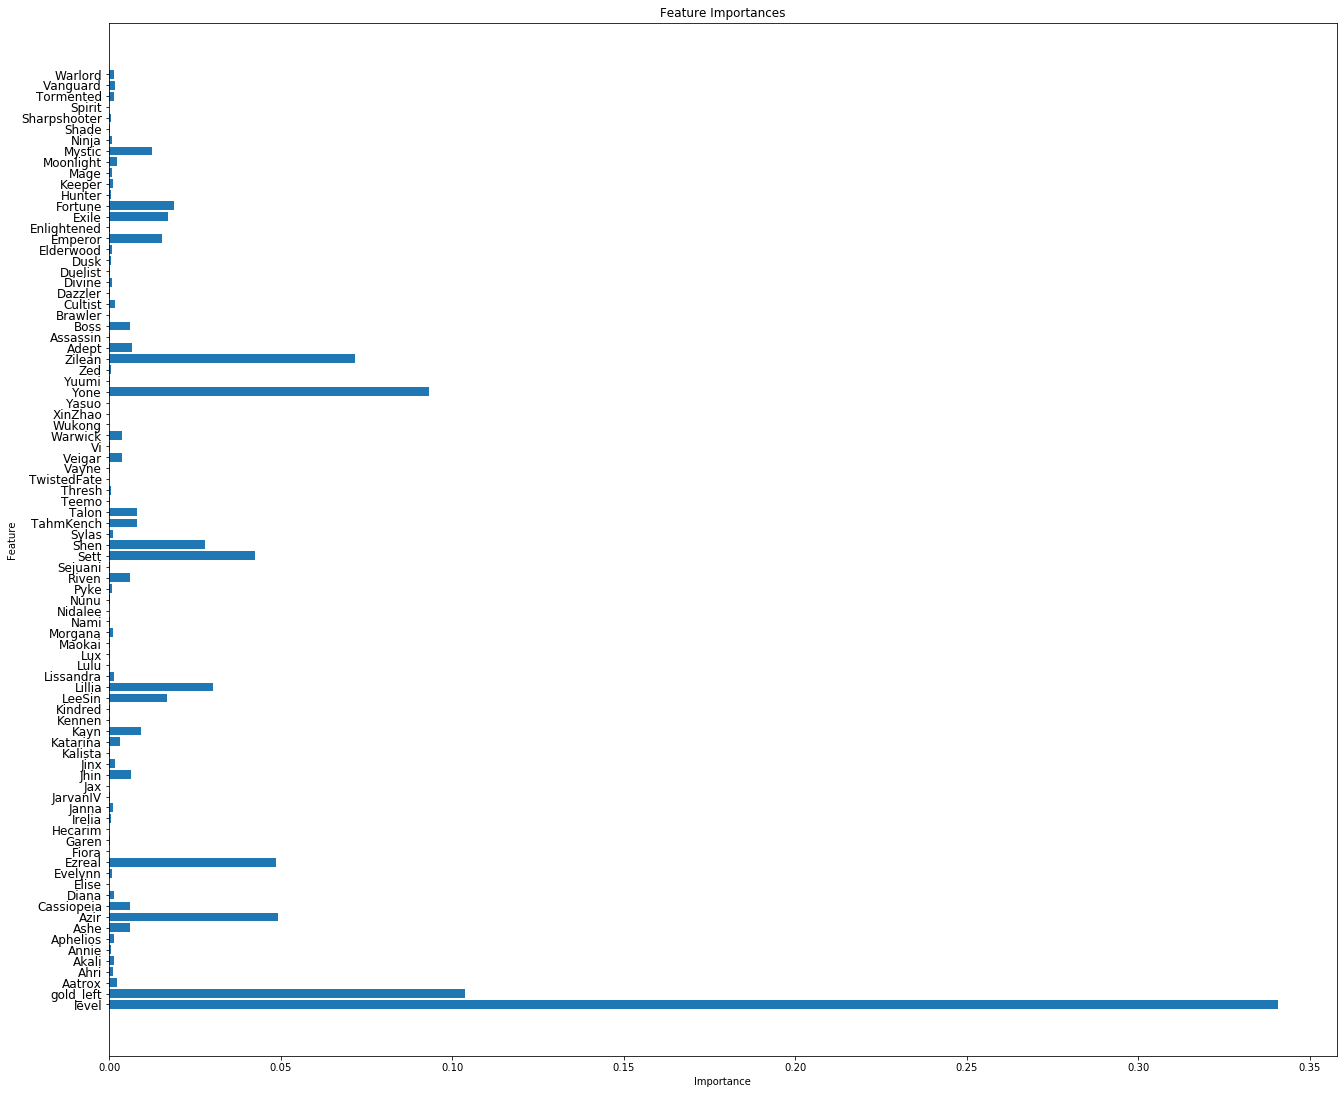

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

importances = bestModel.featureImportances
y_values = list(range(len(importances)))
plt.barh(y_values, importances)
plt.yticks(y_values, cols_in, rotation=0, fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gcf().set_size_inches(22,19)

### Predict on training

In [33]:
predictions_gridtrain = model_rf.transform(trainingData)
predictions_gridtrain.select('placement','features','rawPrediction','probability','prediction').show(truncate=True)

+---------+--------------------+--------------------+--------------------+----------+
|placement|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+--------------------+--------------------+----------+
|        1|(86,[0,1,4,10,26,...|[0.0,1.3781546793...|[0.0,0.0689077339...|       8.0|
|        1|(86,[0,17,18,32,3...|[0.0,1.2070868259...|[0.0,0.0603543412...|       4.0|
|        1|(86,[0,9,17,18,32...|[0.0,1.4510271496...|[0.0,0.0725513574...|       7.0|
|        1|(86,[0,1,17,20,28...|[0.0,4.4508392791...|[0.0,0.2225419639...|       2.0|
|        1|(86,[0,1,17,18,32...|[0.0,2.0337776649...|[0.0,0.1016888832...|       4.0|
|        1|(86,[0,1,17,18,32...|[0.0,3.5431357078...|[0.0,0.1771567853...|       1.0|
|        1|(86,[0,1,17,18,24...|[0.0,5.3215245487...|[0.0,0.2660762274...|       1.0|
|        1|(86,[0,1,17,18,20...|[0.0,2.8693266986...|[0.0,0.1434663349...|       3.0|
|        1|(86,[0,1,17,18,32...|[0.0,2.3098674098...|[

In [34]:
print(allmetrics(predictions_gridtrain))

 Accuracy is: 0.2881689845084807
 Recall is 0.2881689845084807
 Precision is: 0.2563401501814717 


### Predict on test

In [35]:
predictions_grid = model_rf.transform(testData)
predictions_grid.select('placement','features','rawPrediction','probability','prediction').show(truncate=True)

+---------+--------------------+--------------------+--------------------+----------+
|placement|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+--------------------+--------------------+----------+
|        1|(86,[0,1,9,22,39,...|[0.0,0.8314041075...|[0.0,0.0415702053...|       8.0|
|        1|(86,[0,1,17,18,24...|[0.0,5.2774196222...|[0.0,0.2638709811...|       1.0|
|        1|(86,[0,1,17,18,30...|[0.0,2.3563438580...|[0.0,0.1178171929...|       4.0|
|        1|(86,[0,1,8,15,19,...|[0.0,1.7359661884...|[0.0,0.0867983094...|       6.0|
|        1|(86,[0,1,8,11,19,...|[0.0,2.6158181476...|[0.0,0.1307909073...|       4.0|
|        1|(86,[0,1,7,27,33,...|[0.0,3.2153488767...|[0.0,0.1607674438...|       1.0|
|        1|(86,[0,1,7,17,27,...|[0.0,3.4114392139...|[0.0,0.1705719606...|       1.0|
|        1|(86,[0,1,7,17,27,...|[0.0,4.1858377580...|[0.0,0.2092918879...|       1.0|
|        1|(86,[0,1,7,17,18,...|[0.0,1.7803160791...|[

In [36]:
rf_eval = MulticlassClassificationEvaluator(labelCol="placement", predictionCol="prediction", metricName="accuracy")
rf_AUC = rf_eval.evaluate(predictions_grid, {rf_eval.metricName:"accuracy"})


print("AUC = %.2f" % rf_AUC)

AUC = 0.29


In [37]:
print(allmetrics(predictions_grid))

 Accuracy is: 0.2876677639908838
 Recall is 0.2876677639908838
 Precision is: 0.2557029592798839 


## Naive Bayes

#### Very bad performance: only 12% accuracy

In [38]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(trainingData, testData) = output_data_class.randomSplit([0.7, 0.3],seed=0)

# create the trainer and set its parameters
nb = NaiveBayes(labelCol='placement',featuresCol='features', smoothing=1.0, modelType="multinomial")

# train the model
model_nb = nb.fit(trainingData)

# select example rows to display.
predictions_nb = model_nb.transform(testData)
predictions_nb.show(truncate=True)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="placement", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions_nb)
print("Test set accuracy = " + str(accuracy))

+---------+-----+---------+------+----+-----+-----+--------+----+----+----------+-----+-----+-------+------+-----+-----+-------+------+-----+--------+---+----+----+-------+--------+----+------+-------+------+------+---------+----+---+------+-------+----+-------+----+----+-----+-------+----+----+-----+---------+-----+-----+------+-----------+-----+------+---+-------+------+-------+-----+----+-----+---+------+-----+--------+----+-------+-------+-------+------+-------+----+---------+-------+-----------+-----+-------+------+------+----+---------+------+-----+-----+------------+------+---------+--------+-------+--------------------+--------------------+--------------------+----------+
|placement|level|gold_left|Aatrox|Ahri|Akali|Annie|Aphelios|Ashe|Azir|Cassiopeia|Diana|Elise|Evelynn|Ezreal|Fiora|Garen|Hecarim|Irelia|Janna|JarvanIV|Jax|Jhin|Jinx|Kalista|Katarina|Kayn|Kennen|Kindred|LeeSin|Lillia|Lissandra|Lulu|Lux|Maokai|Morgana|Nami|Nidalee|Nunu|Pyke|Riven|Sejuani|Sett|Shen|Sylas|TahmKench

Test set accuracy = 0.11998151875002777


In [39]:
print(allmetrics(predictions_nb))

 Accuracy is: 0.11998151875002777
 Recall is 0.11998151875002776
 Precision is: 0.12067468529069988 


In [40]:
from pyspark.ml.stat import Correlation

vector_col = "features"
matrix = Correlation.corr(output_data_class, vector_col)
matrix.collect()

/home/hpsa13/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(pearson(features)=DenseMatrix(86, 86, [1.0, -0.2605, 0.0609, -0.0162, -0.0818, -0.0709, -0.1576, 0.0575, ..., -0.312, -0.1312, -0.0381, 0.1707, -0.1817, 0.0371, 0.0568, 1.0], False))]

In [41]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        , -0.26053246,  0.06092807, ...,  0.03712395,
        0.05680619,  1.        ])

In [42]:
pd.set_option('display.max_colwidth', -1)  # Show the entire column 
pd.options.display.max_columns = 200 

<ipython-input-42-dc87b4eca211>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # Show the entire column


In [43]:
pandas_df = data_class.select("*").toPandas()

In [44]:
pandas_df.corr()

,placement,level,gold_left,Aatrox,Ahri,Akali,Annie,Aphelios,Ashe,Azir,Cassiopeia,Diana,Elise,Evelynn,Ezreal,Fiora,Garen,Hecarim,Irelia,Janna,JarvanIV,Jax,Jhin,Jinx,Kalista,Katarina,Kayn,Kennen,Kindred,LeeSin,Lillia,Lissandra,Lulu,Lux,Maokai,Morgana,Nami,Nidalee,Nunu,Pyke,Riven,Sejuani,Sett,Shen,Sylas,TahmKench,Talon,Teemo,Thresh,TwistedFate,Vayne,Veigar,Vi,Warwick,Wukong,XinZhao,Yasuo,Yone,Yuumi,Zed,Zilean,Adept,Assassin,Boss,Brawler,Cultist,Dazzler,Divine,Duelist,Dusk,Elderwood,Emperor,Enlightened,Exile,Fortune,Hunter,Keeper,Mage,Moonlight,Mystic,Ninja,Shade,Sharpshooter,Spirit,Tormented,Vanguard,Warlord
placement,1.000000,-0.535271,0.076248,-0.017393,-0.021548,-0.022195,0.041031,0.008182,-0.037401,-0.244015,-0.074924,-0.017600,0.037097,-0.011961,-0.190122,0.010266,0.020026,0.044052,-0.051237,-0.005055,0.019287,0.000161,-0.053940,0.030317,-0.012610,0.005016,-0.154359,0.012408,0.020274,-0.171329,-0.185738,-0.016357,-0.003584,-0.050567,0.015054,-0.036759,-0.006987,0.006756,0.002666,-0.021052,-0.049420,0.012627,-0.191276,-0.141786,0.017365,0.104583,-0.047374,0.012294,0.038689,0.003502,-0.007707,-0.018079,0.011404,-0.061842,0.029963,-0.005764,-0.014337,-0.287248,0.000614,-0.011150,-0.295080,-0.144456,-0.010574,-0.140234,-0.012592,-0.063610,-0.084188,-0.049964,-0.041730,-0.031291,-0.021698,-0.190569,-0.010273,-0.206318,0.112029,0.014889,-0.053137,-0.033822,0.003725,-0.144613,-0.040314,-0.060623,0.020370,0.041228,-0.102704,0.066660,-0.041572
level,-0.535271,1.000000,-0.260532,0.060928,-0.016162,-0.081836,-0.070888,-0.157639,0.057471,0.307220,0.105180,-0.119807,0.000792,-0.012547,0.231371,-0.043644,-0.008815,-0.040450,0.030375,-0.063758,0.019986,-0.009309,0.104517,-0.014354,0.009533,-0.011222,0.227780,-0.033571,-0.074087,0.212017,0.229152,-0.129367,-0.027269,0.023361,-0.010061,0.001697,-0.038011,0.003033,0.009687,-0.054162,0.109110,0.017137,0.262603,0.104915,-0.134773,-0.074342,-0.029154,-0.039904,0.001946,-0.002205,0.031931,-0.020768,0.006591,0.055816,-0.019555,0.005167,-0.014021,0.313939,-0.048893,-0.068343,0.330601,0.173253,-0.091001,0.235785,0.056087,0.126686,0.061305,0.068449,0.048609,0.115777,0.048643,0.282356,-0.037215,0.240008,-0.063349,-0.030158,0.157574,0.025976,-0.185677,0.175156,-0.007910,0.074727,0.031584,-0.083844,0.198964,0.012075,0.095127
gold_left,0.076248,-0.260532,1.000000,-0.026301,-0.007261,0.013741,0.024708,0.025674,-0.033871,-0.060856,-0.044003,0.032266,0.018396,0.005451,-0.048311,0.021563,0.032375,0.011238,-0.043443,0.001424,0.014125,-0.009426,-0.026402,0.022337,0.006917,0.021393,-0.036990,0.004704,-0.007103,-0.043512,-0.045812,0.033176,0.000959,-0.035770,0.007703,-0.024744,0.018478,0.028377,-0.011717,0.009797,-0.036336,-0.006683,-0.045626,-0.058630,0.023534,0.050763,-0.009077,0.018909,-0.016197,0.026394,-0.007842,0.002359,0.011987,-0.040460,0.022598,0.005830,0.008573,-0.071007,-0.003235,0.008106,-0.072437,-0.077433,0.021594,-0.049595,-0.010806,-0.023420,-0.037588,-0.043122,-0.002656,-0.039768,-0.016226,-0.066474,-0.014805,-0.065470,0.044005,-0.023969,-0.028692,0.000700,0.044026,-0.080020,-0.020611,-0.012083,0.007475,0.003793,-0.039030,-0.000015,0.006473
Aatrox,-0.017393,0.060928,-0.026301,1.000000,0.142564,-0.114035,-0.089927,-0.106766,-0.204397,0.056224,0.369328,-0.100565,0.195917,0.117799,-0.163148,-0.091839,-0.029933,-0.023462,-0.272006,-0.096187,-0.056122,-0.164713,0.432134,0.073990,0.081464,-0.087021,0.020138,-0.060412,-0.147596,-0.139006,0.081568,-0.104789,-0.143209,-0.240676,-0.150470,-0.159882,-0.088976,-0.029920,-0.180564,-0.001598,0.296626,0.263505,-0.131550,-0.184280,-0.107580,-0.063226,-0.140024,0.046624,0.392786,0.133155,0.267108,-0.129348,-0.099770,-0.253809,-0.013063,-0.103842,-0.096765,-0.152314,0.061999,-0.085813,0.193973,-0.269078,-0.134651,-0.143707,-0.268835,0.584752,-0.290940,-0.306589,-0.136838,0.388778,-0.220257,0.066922,-0.246466,-0.187046,0.069531,-0.251599,0.167160,-0.023615,-0.146002,0.157832,-0.188142,0.011761,0.284592,0.031731,0.023845,0.647649,-0.064461
Ahri,-0.021548,-0.016162,

In [45]:
pandas_df.head()

,placement,level,gold_left,Aatrox,Ahri,Akali,Annie,Aphelios,Ashe,Azir,Cassiopeia,Diana,Elise,Evelynn,Ezreal,Fiora,Garen,Hecarim,Irelia,Janna,JarvanIV,Jax,Jhin,Jinx,Kalista,Katarina,Kayn,Kennen,Kindred,LeeSin,Lillia,Lissandra,Lulu,Lux,Maokai,Morgana,Nami,Nidalee,Nunu,Pyke,Riven,Sejuani,Sett,Shen,Sylas,TahmKench,Talon,Teemo,Thresh,TwistedFate,Vayne,Veigar,Vi,Warwick,Wukong,XinZhao,Yasuo,Yone,Yuumi,Zed,Zilean,Adept,Assassin,Boss,Brawler,Cultist,Dazzler,Divine,Duelist,Dusk,Elderwood,Emperor,Enlightened,Exile,Fortune,Hunter,Keeper,Mage,Moonlight,Mystic,Ninja,Shade,Sharpshooter,Spirit,Tormented,Vanguard,Warlord
0,3,7,18,0,0,3,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,3,0,1,0,0,0,0,0,1
1,5,8,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,4,0,0,0,0,2,0,1,0,0,2,0,0,4,0,0,2,0
2,4,7,1,1,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,2,0,0,0,2,0,0,0,0,2,0,0,3,0,4,1,0,0,2,0,3,0
3,8,8,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,2,2,0,0,6,0,0,0,1,2,0,1,0,0,0,0,0,0,0,2,0
4,1,9,1,2,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,4,0,1,0,0,0,0,3,3,0,2,1,0,0,0,0,2,1


# Linear Regression with DecisionTree 

In [22]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [23]:
data_class_reg=data_final_clean.drop('index','patch_version', 'match_id', 'puuid','chosen_unit','chosen_trait','time_in_game','players_eliminated', 'last_round','placement')

In [29]:
cols_in_reg = [col for col in data_class_reg.columns if col !='total_dmg_to_players']
assembler = VectorAssembler(inputCols=cols_in_reg, outputCol="X_vector")

output_class_reg = assembler.transform(data_class_reg)
output_class_reg.select("X_vector").show(8,truncate=True)

+--------------------+
|            X_vector|
+--------------------+
|(86,[0,1,4,10,24,...|
|(86,[0,1,9,21,22,...|
|(86,[0,1,2,3,5,9,...|
|(86,[0,7,13,16,31...|
|(86,[0,1,2,8,9,26...|
|(86,[0,1,2,3,8,9,...|
|(86,[0,1,5,17,18,...|
|(86,[0,4,24,26,38...|
+--------------------+
only showing top 8 rows



In [30]:
output_class_reg.columns

['level',
 'gold_left',
 'total_dmg_to_players',
 'Aatrox',
 'Ahri',
 'Akali',
 'Annie',
 'Aphelios',
 'Ashe',
 'Azir',
 'Cassiopeia',
 'Diana',
 'Elise',
 'Evelynn',
 'Ezreal',
 'Fiora',
 'Garen',
 'Hecarim',
 'Irelia',
 'Janna',
 'JarvanIV',
 'Jax',
 'Jhin',
 'Jinx',
 'Kalista',
 'Katarina',
 'Kayn',
 'Kennen',
 'Kindred',
 'LeeSin',
 'Lillia',
 'Lissandra',
 'Lulu',
 'Lux',
 'Maokai',
 'Morgana',
 'Nami',
 'Nidalee',
 'Nunu',
 'Pyke',
 'Riven',
 'Sejuani',
 'Sett',
 'Shen',
 'Sylas',
 'TahmKench',
 'Talon',
 'Teemo',
 'Thresh',
 'TwistedFate',
 'Vayne',
 'Veigar',
 'Vi',
 'Warwick',
 'Wukong',
 'XinZhao',
 'Yasuo',
 'Yone',
 'Yuumi',
 'Zed',
 'Zilean',
 'Adept',
 'Assassin',
 'Boss',
 'Brawler',
 'Cultist',
 'Dazzler',
 'Divine',
 'Duelist',
 'Dusk',
 'Elderwood',
 'Emperor',
 'Enlightened',
 'Exile',
 'Fortune',
 'Hunter',
 'Keeper',
 'Mage',
 'Moonlight',
 'Mystic',
 'Ninja',
 'Shade',
 'Sharpshooter',
 'Spirit',
 'Tormented',
 'Vanguard',
 'Warlord',
 'X_vector']

#### Non c'è bisogno di usare il vector indexer, dato che usiamo già attributi numerici

In [31]:
(trainingData, testData) = output_class_reg.randomSplit([0.7, 0.3],seed=0)

dt = DecisionTreeRegressor(featuresCol ='X_vector', labelCol = 'total_dmg_to_players')

dt_model = dt.fit(trainingData)

dt_predictions = dt_model.transform(testData)

dt_evaluator = RegressionEvaluator(
    labelCol="total_dmg_to_players", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 37.4219


In [32]:
dt_evaluatorR2 = RegressionEvaluator(
    labelCol="total_dmg_to_players", predictionCol="prediction", metricName="r2")
r2 = dt_evaluatorR2.evaluate(dt_predictions)
print("R-squared on test data = %s" % r2)
\
#C' è una forte correlazione positiva tra la variabile total_dmg_to_players e placement, R è vicino a 1

R-squared on test data = 0.42250426146278963


In [33]:
dt_predictions.select("prediction", "total_dmg_to_players", "X_vector").show(200)

+------------------+--------------------+--------------------+
|        prediction|total_dmg_to_players|            X_vector|
+------------------+--------------------+--------------------+
| 11.29021372328459|                   6|(86,[0,15,19,36,4...|
| 11.29021372328459|                  10|(86,[0,1],[5.0,15...|
| 6.723168023686158|                   0|(86,[0,1,49,54,67...|
|33.457709184445456|                  36|(86,[0,6,10,20,27...|
|33.457709184445456|                  39|(86,[0,14,17,18,3...|
|33.457709184445456|                  19|(86,[0,1,3,6,10,2...|
|33.457709184445456|                  21|(86,[0,1,2,11,22,...|
|33.457709184445456|                  26|(86,[0,1,6,17,27,...|
|33.457709184445456|                  56|(86,[0,1,5,14,18,...|
|33.457709184445456|                  11|(86,[0,1,3,9,16,1...|
|33.457709184445456|                  32|(86,[0,1,9,12,27,...|
|33.457709184445456|                  20|(86,[0,1,4,10,30,...|
|33.457709184445456|                  65|(86,[0,1,6,7,2